In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U tensorflow-text==2.9
!pip install -q tf-models-official==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 6.5 MB/s 
     |████████████████████████████████| 1.8 MB 6.8 MB/s 
     |████████████████████████████████| 352 kB 48.8 MB/s 
     |████████████████████████████████| 1.1 MB 14.2 MB/s 
     |████████████████████████████████| 238 kB 7.7 MB/s 
     |████████████████████████████████| 1.3 MB 18.7 MB/s 
     |████████████████████████████████| 118 kB 14.2 MB/s 
     |████████████████████████████████| 43 kB 574 kB/s 


In [ ]:
import os
import shutil

import json

from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization 

import tensorboard
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
import sklearn.naive_bayes as nv
from sklearn import metrics
import seaborn as sns; sns.set()

from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn import svm

import gc
from scipy import ndimage
from subprocess import check_output
import cv2
pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import re
import nltk
from nltk.corpus import stopwords

In [ ]:
print(tf. __version__)

2.9.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# input data Directory
# input_file_dir = '/content/drive/MyDrive/Colab Notebooks/ML Assignments/Project/finalMergedData.json'
input_file_dir = '/content/drive/MyDrive/finalMergedData.json'

In [ ]:
# import json file as dataframe
df = pd.read_json(input_file_dir)
df.info()
print(df.describe)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50906 entries, 0 to 50905
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   topic       50906 non-null  object
 1   source      50906 non-null  object
 2   url         50906 non-null  object
 3   title       50906 non-null  object
 4   author      50906 non-null  object
 5   date        50906 non-null  object
 6   content     50906 non-null  object
 7   source_url  50906 non-null  object
 8   bias_text   50906 non-null  object
dtypes: object(9)
memory usage: 3.5+ MB
<bound method NDFrame.describe of               topic                 source  \
0         elections               Townhall   
1       white_house               Townhall   
2       white_house  New York Times - News   
3         elections        NPR Online News   
4       white_house               BBC News   
...             ...                    ...   
50901      Politics              Roll Call   
50902     

In [ ]:
df.head()

,topic,source,url,title,author,date,content,source_url,bias_text
0,elections,Townhall,http://townhall.com/tipsheet/danieldoherty/201...,Poll: Nearly 6 in 10 Republicans Hope Romney Runs,"Daniel Doherty, Katie Pavlich, Julio Rosas, ""C...",2015-01-20,"By a two-to-one margin, respondents who partic...",www.townhall.com,right
1,white_house,Townhall,https://townhall.com/tipsheet/leahbarkoukis/20...,Trump's Most Popular Tweets of 2018,"Leah Barkoukis, Matt Vespa, Julio Rosas, Katie...",2019-01-01,President Trump loves to tweet as a way to dir...,www.townhall.com,right
2,white_house,New York Times - News,http://www.nytimes.com/politics/first-draft/20...,"For Secret Service Chief, Revelations Could Th...",David Streitfeld,2014-09-30,"For Secret Service Chief, Revelations Could Th...",www.nytimes.com,left
3,elections,NPR Online News,http://www.npr.org/2016/06/20/482779372/embatt...,Embattled Trump Campaign Manager Out,"Jessica Taylor, Sarah Mccammon",2016-06-20,Trump Ousts Embattled Campaign Manager\n\nEnla...,www.npr.org,center
4,white_house,BBC News,https://www.bbc.com/news/world-us-canada-46133268,White House suspends credentials for CNN's Jim...,,,Media playback is unsupported on your device M...,www.bbc.com,center


In [ ]:
df.shape

(50906, 9)

In [ ]:
# drop other columns except content (X) and bias_text (Y).
nbdf = df.iloc[:,6:9].drop(columns='source_url')
nbdf['bias_text'] = nbdf['bias_text'].str.capitalize()
nbdf.head()

,content,bias_text
0,"By a two-to-one margin, respondents who partic...",Right
1,President Trump loves to tweet as a way to dir...,Right
2,"For Secret Service Chief, Revelations Could Th...",Left
3,Trump Ousts Embattled Campaign Manager\n\nEnla...,Center
4,Media playback is unsupported on your device M...,Center


In [ ]:
# labels
nbdf_labels = nbdf['bias_text'].unique()
print(nbdf_labels)

['Right' 'Left' 'Center' 'Lean left' 'Lean right' 'Mixed'
 'Political news media bias rating: not rated']


In [ ]:
# summary of bias_text
nbdf.groupby('bias_text').describe()

content         \
                                              count unique   
bias_text                                                    
Center                                        12745  12691   
Lean left                                      4795   4610   
Lean right                                     2078   2043   
Left                                          15098  14938   
Mixed                                            57     57   
Political news media bias rating: not rated      10      9   
Right                                         16123  15600   

                                                                                                \
                                                                                           top   
bias_text                                                                                        
Center                                       Biden's ability to reshape U.S. judiciary hang...   
Lean left                                    Why did this happen?\n\nPlease make sure your ...   
Lean right                                                                                       
Left                                         The United Nations' weather agency says the st...   
Mixed                                        From the Left\n\nThe left opposes the decision...   
Political news media bias rating: not rated                                                      
Right                                                                                            

                                                  
                                            freq  
bias_text                                         
Center                                        19  
Lean left                                    118  
Lean right                                    34  
Left                                          79  
Mixed                                          1  
Political news media bias rating: not rated    2  
Right                                        337

In [ ]:
# drop categories that are not useful (Mixed, not rated, lean left, lean right)
nbdf_filtered = nbdf[nbdf['bias_text'] != "Political news media bias rating: not rated"]  
nbdf_filtered = nbdf_filtered[nbdf_filtered['bias_text'] != "Mixed"]
nbdf_filtered = nbdf_filtered[nbdf_filtered['bias_text'] != "Lean left"]
nbdf_filtered = nbdf_filtered[nbdf_filtered['bias_text'] != "Lean right"]
nbdf_filtered = nbdf_filtered.drop_duplicates(subset=['content'], keep='first')
nbdf_filtered = nbdf_filtered[(nbdf_filtered['content'] != "")]

In [ ]:
# summary of Y
nbdf_filterd_labels = nbdf_filtered['bias_text'].unique()
print(nbdf_filterd_labels)

['Right' 'Left' 'Center']


In [ ]:
# Summary of Y without duplicate
print(nbdf.shape)
print(nbdf_filtered.shape)
nbdf_filtered.groupby('bias_text').describe()

(50906, 2)
(43221, 2)


content                                                            \
            count unique                                                top   
bias_text                                                                     
Center      12689  12689  Trump Ousts Embattled Campaign Manager\n\nEnla...   
Left        14937  14937  For Secret Service Chief, Revelations Could Th...   
Right       15595  15595  By a two-to-one margin, respondents who partic...   

                
          freq  
bias_text       
Center       1  
Left         1  
Right        1

In [ ]:
# download stopword list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# data cleaning: make lowercase, remove special characters and numbers using regex
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = re.sub(r'\W+', '', text) # this removes all special characters # r means raw string
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text
nbdf_filtered['content'] = nbdf_filtered['content'].apply(clean_text)
# remove all digits
nbdf_filtered['content'] = nbdf_filtered['content'].str.replace('\d+', '')

nbdf_filtered.head()

<ipython-input-17-8f3b9852598d>:14: FutureWarning:

The default value of regex will change from True to False in a future version.



,content,bias_text
0,twotoone margin respondents participated recen...,Right
1,president trump loves tweet way directly reach...,Right
2,secret service chief revelations could threate...,Left
3,trump ousts embattled campaign managerenlarge ...,Center
4,media playback unsupported device media captio...,Center


In [ ]:
def countNumWordsOfContent(text):
  return len(text.split())

# remove those articles with actual words less than 30
nbdf_filtered = nbdf_filtered[nbdf_filtered['content'].apply(countNumWordsOfContent) >= 50]

nbdf_filtered = nbdf_filtered.drop_duplicates(subset=['content'], keep='first')
nbdf_filtered = nbdf_filtered[(nbdf_filtered['content'] != "")]
nbdf_filtered.groupby('bias_text').describe()

content                                                            \
            count unique                                                top   
bias_text                                                                     
Center      12473  12473  trump ousts embattled campaign managerenlarge ...   
Left        14886  14886  secret service chief revelations could threate...   
Right       15572  15572  twotoone margin respondents participated recen...   

                
          freq  
bias_text       
Center       1  
Left         1  
Right        1

In [ ]:
X_ser = nbdf_filtered['content']
Y_ser = nbdf_filtered["bias_text"]

X_df = nbdf_filtered.iloc[:,:-1]
Y_df = nbdf_filtered.iloc[:,-1:]
# split into traing and test dataset with 7:3 ratio
X_train_ser, X_test_ser, Y_train_ser, Y_test_ser = train_test_split(X_ser, Y_ser, test_size=0.3, random_state=53)
X_train_df, X_test_df, Y_train_df, Y_test_df = train_test_split(X_df, Y_df, test_size=0.3, random_state=53)

print(X_train_ser.shape)
print(Y_train_ser.shape)
print(X_train_ser.ndim)
print(Y_train_ser.ndim)
print(type(X_train_ser))
print(type(Y_train_ser))
print()

print(X_test_ser.shape)
print(Y_test_ser.shape)
print(X_test_ser.ndim)
print(Y_test_ser.ndim)
print(type(X_test_ser))
print(type(Y_test_ser))
print()

print(X_train_df.shape)
print(Y_train_df.shape)
print(X_train_df.ndim)
print(Y_train_df.ndim)
print(type(X_train_df))
print(type(Y_train_df))

(30051,)
(30051,)
1
1
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>

(12880,)
(12880,)
1
1
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>

(30051, 1)
(30051, 1)
2
2
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
Y_train_df['bias_text'].value_counts()

Right     10969
Left      10354
Center     8728
Name: bias_text, dtype: int64

In [ ]:
# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_train_under, Y_train_under = undersample.fit_resample(X_train_df, Y_train_df)
X_train_under, Y_train_under = undersample.fit_resample(X_train_under, Y_train_under)
X_train_under, Y_train_under = undersample.fit_resample(X_train_under, Y_train_under)
X_train_under, Y_train_under = undersample.fit_resample(X_train_under, Y_train_under)

print(X_train_under)
print(Y_train_under)

                                                 content
0      supreme court rules obamacare subsidies legale...
1      fiscal cliff deal reach yesthe facetoface meet...
2      congressmans exit closes book watergate babies...
3      columbia schillary clinton bernie sanders made...
4      chicago oct  reuters planting roughly halfway ...
...                                                  ...
26179  consulting company avalere health provided lea...
26180  months conflict confusion fraudtainted house r...
26181  comstock stockbyte getty leaders stand speak s...
26182  possible breakthrough legislative proposal gun...
26183  material poverty us facts people census bureau...

[26184 rows x 1 columns]
      bias_text
0        Center
1        Center
2        Center
3        Center
4        Center
...         ...
26179     Right
26180     Right
26181     Right
26182     Right
26183     Right

[26184 rows x 1 columns]


Counter Vectorizer

In [ ]:
# initalize count vectoizer
count_vectorizer = CountVectorizer(stop_words="english")

# imbalance data
count_train = count_vectorizer.fit_transform(X_train_ser.values)
count_test = count_vectorizer.transform(X_test_ser.values)

# balanced data with undersampling
count_train_under = count_vectorizer.fit_transform(X_train_under["content"].values)
count_test_under = count_vectorizer.transform(X_test_df["content"].values)

In [ ]:
# define oversampling strategy
smote = SMOTE()

# fit and apply the transform
X_train_SMOTE, Y_train_SMOTE = smote.fit_resample(count_train, Y_train_df)

In [ ]:
print(Y_train_SMOTE['bias_text'].value_counts())
print("\n")
print(Y_train_under['bias_text'].value_counts())
print("\n")
print(Y_train_df['bias_text'].value_counts())

Left      10969
Right     10969
Center    10969
Name: bias_text, dtype: int64


Center    8728
Left      8728
Right     8728
Name: bias_text, dtype: int64


Right     10969
Left      10354
Center     8728
Name: bias_text, dtype: int64


Naive Bayes

0.6385869565217391
[[2779 1129  695]
 [ 679 3080  773]
 [ 346 1033 2366]]


Text(30.5, 0.5, 'Prediction')

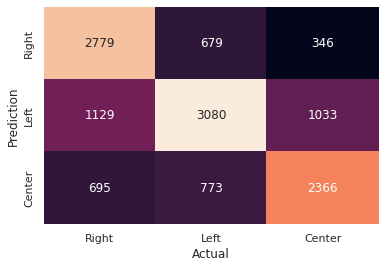

In [ ]:
# imbalanced multinomial naive bayes model
naive_bayse_model_CV = nv.MultinomialNB()
# training
naive_bayse_model_CV.fit(count_train, Y_train_ser)
Y_pred_CV = naive_bayse_model_CV.predict(count_test)
# accuracy
score_CV = metrics.accuracy_score(Y_test_ser, Y_pred_CV)
print(score_CV)

cm_cv = metrics.confusion_matrix(Y_test_ser, Y_pred_CV, labels=nbdf_filterd_labels)
print(cm_cv)
# drow heatmap for confusion matrix
sns.heatmap(cm_cv.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

0.6325310559006211
[[2478 1164  961]
 [ 509 3012 1011]
 [ 229  859 2657]]


Text(30.5, 0.5, 'Prediction')

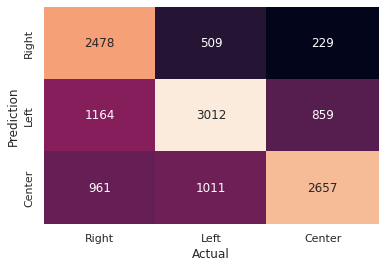

In [ ]:
# balanced multinomial naive bayes with undersampling data
naive_bayse_model_CV_under = nv.MultinomialNB()
# training
naive_bayse_model_CV_under.fit(count_train_under, Y_train_under["bias_text"])
Y_pred_CV_under = naive_bayse_model_CV_under.predict(count_test_under)
# accuracy
score_under = metrics.accuracy_score(Y_test_df["bias_text"], Y_pred_CV_under)
print(score_under)

cm_under = metrics.confusion_matrix(Y_test_ser, Y_pred_CV_under, labels=nbdf_filterd_labels)
print(cm_under)
# drow heatmap for confusion matrix
sns.heatmap(cm_under.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

0.6354813664596274
[[2660 1122  821]
 [ 622 3050  860]
 [ 303  967 2475]]


Text(30.5, 0.5, 'Prediction')

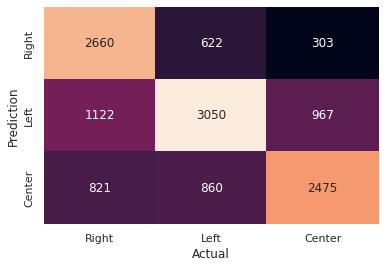

In [ ]:
# balanced multinomial naive bayes with Oversampling data
naive_bayse_model_CV_over = nv.MultinomialNB()
# training
naive_bayse_model_CV_over.fit(X_train_SMOTE, Y_train_SMOTE["bias_text"])
Y_pred_CV_over = naive_bayse_model_CV_over.predict(count_test)
# accuracy
score_over = metrics.accuracy_score(Y_test_df["bias_text"], Y_pred_CV_over)
print(score_over)

cm_over = metrics.confusion_matrix(Y_test_ser, Y_pred_CV_over, labels=nbdf_filterd_labels)
print(cm_over)
# drow heatmap for confusion matrix
sns.heatmap(cm_over.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

0.6645962732919255
[[2942  907  754]
 [ 745 2905  882]
 [ 325  707 2713]]


Text(30.5, 0.5, 'Prediction')

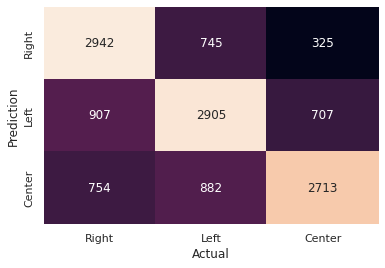

In [ ]:
# imbalanced complement Naive Bayes naive bayes model
complement_naive_bayse_model_CV = nv.ComplementNB()
# training
complement_naive_bayse_model_CV.fit(count_train, Y_train_ser)
complement_Y_pred_CV = complement_naive_bayse_model_CV.predict(count_test)
# accuracy
complement_score_CV = metrics.accuracy_score(Y_test_ser, complement_Y_pred_CV)
print(complement_score_CV)

complement_cm_cv = metrics.confusion_matrix(Y_test_ser, complement_Y_pred_CV, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(complement_cm_cv)
# drow heatmap for confusion matrix
sns.heatmap(complement_cm_cv.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

0.6566770186335403
[[2742  932  929]
 [ 634 2855 1043]
 [ 245  639 2861]]


Text(30.5, 0.5, 'Prediction')

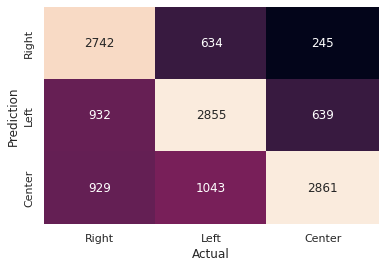

In [ ]:
# balanced data with undersampling
complement_naive_bayse_model_CV_under = nv.ComplementNB()
# training
complement_naive_bayse_model_CV_under.fit(count_train_under, Y_train_under["bias_text"])
complement_Y_pred_CV_under = complement_naive_bayse_model_CV_under.predict(count_test_under)
# accuracy
complement_score_under = metrics.accuracy_score(Y_test_df["bias_text"], complement_Y_pred_CV_under)
print(complement_score_under)

complement_cm_under = metrics.confusion_matrix(Y_test_ser, complement_Y_pred_CV_under, labels=nbdf_filterd_labels)
print(complement_cm_under)
# drow heatmap for confusion matrix
sns.heatmap(complement_cm_under.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

0.662111801242236
[[2868  891  844]
 [ 699 2878  955]
 [ 294  669 2782]]


Text(30.5, 0.5, 'Prediction')

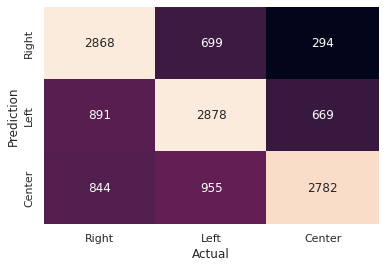

In [ ]:
# balanced data with Oversampling
complement_naive_bayse_model_CV_over = nv.ComplementNB()
# training
complement_naive_bayse_model_CV_over.fit(X_train_SMOTE, Y_train_SMOTE["bias_text"])
complement_Y_pred_CV_over = complement_naive_bayse_model_CV_over.predict(count_test)
# accuracy
complement_score_over = metrics.accuracy_score(Y_test_df["bias_text"], complement_Y_pred_CV_over)
print(complement_score_over)

complement_cm_over = metrics.confusion_matrix(Y_test_ser, complement_Y_pred_CV_over, labels=nbdf_filterd_labels)
print(complement_cm_over)
# drow heatmap for confusion matrix
sns.heatmap(complement_cm_over.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

Term frequency - Inverse Document Frequency

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)

# imbalance data
tfidf_train = tfidf_vectorizer.fit_transform(X_train_ser.values)
tfidf_test = tfidf_vectorizer.transform(X_test_ser.values)

# balanced data with undersampling
tfidf_train_under = tfidf_vectorizer.fit_transform(X_train_under["content"].values)
tfidf_test_under = tfidf_vectorizer.transform(X_test_df["content"].values)

In [ ]:
# define oversampling strategy
smote_TF = SMOTE()

# fit and apply the transform
X_train_SMOTE_TF, Y_train_SMOTE_TF = smote_TF.fit_resample(tfidf_train, Y_train_df)

0.5547360248447205
[[3444 1122   37]
 [1168 3337   27]
 [1406 1975  364]]


Text(30.5, 0.5, 'Prediction')

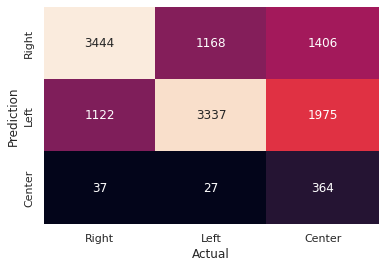

In [ ]:
# imbalanced model
naive_bayse_model_TF = nv.MultinomialNB()
# training
naive_bayse_model_TF.fit(tfidf_train, Y_train_ser)
Y_pred_TF = naive_bayse_model_TF.predict(tfidf_test)
# accuracy
score_TF = metrics.accuracy_score(Y_test_ser, Y_pred_TF)
print(score_TF)

cm_tf = metrics.confusion_matrix(Y_test_ser, Y_pred_TF, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(cm_tf)
# drow heatmap for confusion matrix
sns.heatmap(cm_tf.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

0.5835403726708075
[[1720 1812 1071]
 [ 232 3320  980]
 [ 130 1139 2476]]


Text(30.5, 0.5, 'Prediction')

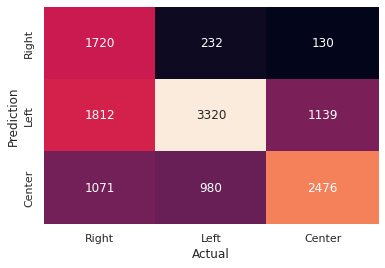

In [ ]:
# balanced data with undersampling
naive_bayse_model_TF_under = nv.MultinomialNB()
# training
naive_bayse_model_TF_under.fit(tfidf_train_under, Y_train_under["bias_text"])
Y_pred_TF_under = naive_bayse_model_TF_under.predict(tfidf_test_under)
# accuracy
score_TF_under = metrics.accuracy_score(Y_test_df["bias_text"], Y_pred_TF_under)
print(score_TF_under)

cm_TF_under = metrics.confusion_matrix(Y_test_ser, Y_pred_TF_under, labels=nbdf_filterd_labels)
print(cm_TF_under)
# drow heatmap for confusion matrix
sns.heatmap(cm_TF_under.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

0.584860248447205
[[1713 1759 1131]
 [ 237 3289 1006]
 [ 127 1087 2531]]


Text(30.5, 0.5, 'Prediction')

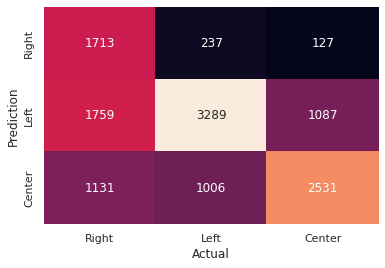

In [ ]:
# balanced data with Oversampling
naive_bayse_model_TF_over = nv.MultinomialNB()
# training
naive_bayse_model_TF_over.fit(X_train_SMOTE_TF, Y_train_SMOTE_TF["bias_text"])
Y_pred_TF_over = naive_bayse_model_TF_over.predict(tfidf_test)
# accuracy
score_over_TF = metrics.accuracy_score(Y_test_df["bias_text"], Y_pred_TF_over)
print(score_over_TF)

cm_over_TF = metrics.confusion_matrix(Y_test_ser, Y_pred_TF_over, labels=nbdf_filterd_labels)
print(cm_over_TF)
# drow heatmap for confusion matrix
sns.heatmap(cm_over_TF.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

0.6045807453416149
[[3379 1072  152]
 [1022 3368  142]
 [1080 1625 1040]]


Text(30.5, 0.5, 'Prediction')

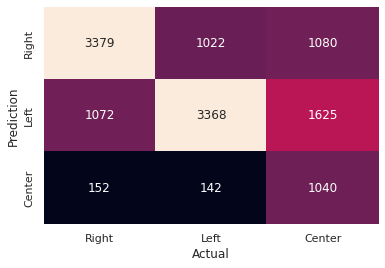

In [ ]:
# imbalanced model
complement_naive_bayse_model_TF = nv.ComplementNB()
# training
complement_naive_bayse_model_TF.fit(tfidf_train, Y_train_ser)
complement_Y_pred_TF = complement_naive_bayse_model_TF.predict(tfidf_test)
# accuracy
complement_score_TF = metrics.accuracy_score(Y_test_ser, complement_Y_pred_TF)
print(complement_score_TF)

complement_cm_TF = metrics.confusion_matrix(Y_test_ser, complement_Y_pred_TF, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(complement_cm_TF)
# drow heatmap for confusion matrix
sns.heatmap(complement_cm_TF.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

0.6201086956521739
[[2137 1429 1037]
 [ 329 3171 1032]
 [ 166  900 2679]]


Text(30.5, 0.5, 'Prediction')

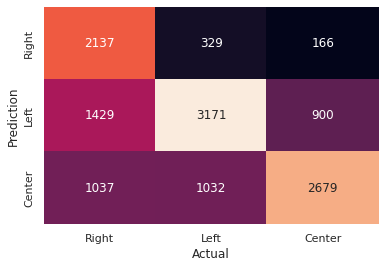

In [ ]:
# balanced data with undersampling
complement_naive_bayse_model_TF_under = nv.ComplementNB()
# training
complement_naive_bayse_model_TF_under.fit(tfidf_train_under, Y_train_under["bias_text"])
complement_Y_pred_TF_under = complement_naive_bayse_model_TF_under.predict(tfidf_test_under)
# accuracy
complement_score_under_TF = metrics.accuracy_score(Y_test_df["bias_text"], complement_Y_pred_TF_under)
print(complement_score_under_TF)

complement_cm_under_TF = metrics.confusion_matrix(Y_test_ser, complement_Y_pred_TF_under, labels=nbdf_filterd_labels)
print(complement_cm_under_TF)
# drow heatmap for confusion matrix
sns.heatmap(complement_cm_under_TF.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

0.6227484472049689
[[2124 1393 1086]
 [ 332 3159 1041]
 [ 168  839 2738]]


Text(30.5, 0.5, 'Prediction')

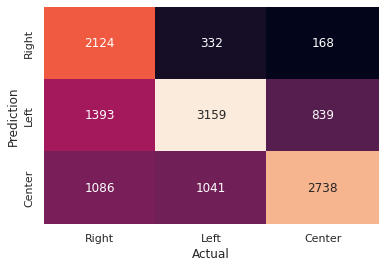

In [ ]:
# balanced data with Oversampling
complement_naive_bayse_model_TF_over = nv.ComplementNB()
# training
complement_naive_bayse_model_TF_over.fit(X_train_SMOTE_TF, Y_train_SMOTE_TF["bias_text"])
complement_Y_pred_TF_over = complement_naive_bayse_model_TF_over.predict(tfidf_test)
# accuracy
complement_score_over_TF = metrics.accuracy_score(Y_test_df["bias_text"], complement_Y_pred_TF_over)
print(complement_score_over_TF)

complement_cm_over_TF = metrics.confusion_matrix(Y_test_ser, complement_Y_pred_TF_over, labels=nbdf_filterd_labels)
print(complement_cm_over_TF)
# drow heatmap for confusion matrix
sns.heatmap(complement_cm_over_TF.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

Support Vecter Machine

Imbalance data, count vector, linear 5 hours

0.7330745341614907
[[3403  703  497]
 [ 728 3170  634]
 [ 408  468 2869]]


Text(30.5, 0.5, 'Prediction')

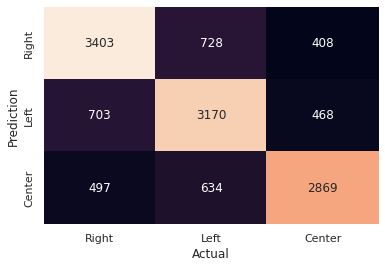

In [ ]:
# imbalanced model
linear_svm_CV = svm.SVC(C=1, kernel='linear')
# training
linear_svm_CV.fit(count_train, Y_train_ser)
Y_pred_linear_svm_CV = linear_svm_CV.predict(count_test)
# accuracy
score_linear_svm_CV = metrics.accuracy_score(Y_test_ser, Y_pred_linear_svm_CV)
print(score_linear_svm_CV)

cm_linear_svm_cv = metrics.confusion_matrix(Y_test_ser, Y_pred_linear_svm_CV, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(cm_linear_svm_cv)
# drow heatmap for confusion matrix
sns.heatmap(cm_linear_svm_cv.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

balanced data with undersampling, count vector, linear took 2hours 47mins

0.7273291925465839
[[3279  734  590]
 [ 671 3174  687]
 [ 387  443 2915]]


Text(30.5, 0.5, 'Prediction')

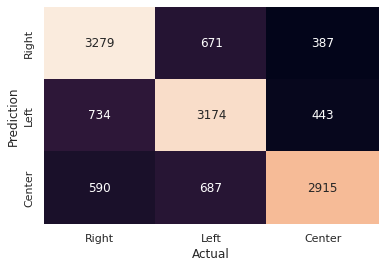

In [ ]:
# balanced data with undersampling
linear_svm_CV_under = svm.SVC(C=1, kernel='linear')
# training
linear_svm_CV_under.fit(count_train_under, Y_train_under["bias_text"])
Y_pred_linear_svm_CV_under = linear_svm_CV_under.predict(count_test_under)
# accuracy
score_linear_svm_CV_under = metrics.accuracy_score(Y_test_df["bias_text"], Y_pred_linear_svm_CV_under)
print(score_linear_svm_CV_under)

cm_linear_svm_cv_under = metrics.confusion_matrix(Y_test_ser, Y_pred_linear_svm_CV_under, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(cm_linear_svm_cv_under)
# drow heatmap for confusion matrix
sns.heatmap(cm_linear_svm_cv_under.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')n
plt.ylabel('Prediction')

balanced data with oversampling, count vector, linear

0.6989906832298136
[[3249  719  635]
 [ 804 3002  726]
 [ 479  514 2752]]


Text(30.5, 0.5, 'Prediction')

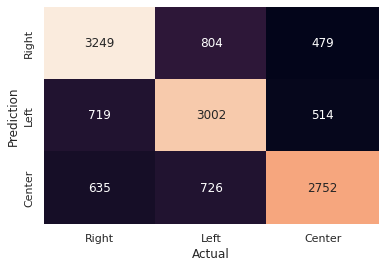

In [ ]:
# balanced data with Oversampling
linear_svm_CV_over = svm.SVC(C=1, kernel='linear')
# training
linear_svm_CV_over.fit(X_train_SMOTE, Y_train_SMOTE["bias_text"])
Y_pred_linear_svm_CV_over = linear_svm_CV_over.predict(count_test)
# accuracy
score_linear_svm_CV_over = metrics.accuracy_score(Y_test_df["bias_text"], Y_pred_linear_svm_CV_over)
print(score_linear_svm_CV_over)

cm_linear_svm_cv_over = metrics.confusion_matrix(Y_test_ser, Y_pred_linear_svm_CV_over, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(cm_linear_svm_cv_over)
# drow heatmap for confusion matrix
sns.heatmap(cm_linear_svm_cv_over.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

imbalanced data, count vector, polynomial took 2hours 47mins

0.4876552795031056
[[4355  117  131]
 [3121 1112  299]
 [2788  143  814]]


Text(30.5, 0.5, 'Prediction')

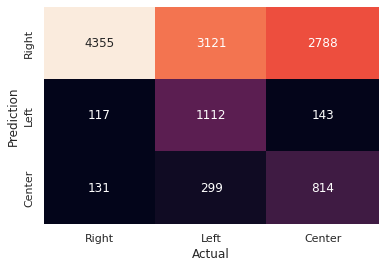

In [ ]:
# imbalanced model
poly_svm_CV = svm.SVC(C=1, kernel='poly')
# training
poly_svm_CV.fit(count_train, Y_train_ser)
Y_pred_poly_svm_CV = poly_svm_CV.predict(count_test)
# accuracy
score_poly_svm_CV = metrics.accuracy_score(Y_test_ser, Y_pred_poly_svm_CV)
print(score_poly_svm_CV)

cm_poly_svm_cv = metrics.confusion_matrix(Y_test_ser, Y_pred_poly_svm_CV, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(cm_poly_svm_cv)
# drow heatmap for confusion matrix
sns.heatmap(cm_poly_svm_cv.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

balanced data with undersampling, count vector, polynomial

0.49138198757763973
[[4319  151  133]
 [3114 1089  329]
 [2703  121  921]]


Text(30.5, 0.5, 'Prediction')

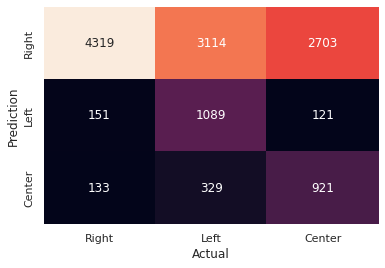

In [ ]:
# balanced data with undersampling
poly_svm_CV_under = svm.SVC(C=1, kernel='poly')
# training
poly_svm_CV_under.fit(count_train_under, Y_train_under["bias_text"])
Y_pred_poly_svm_CV_under = poly_svm_CV_under.predict(count_test_under)
# accuracy
score_poly_svm_CV_under = metrics.accuracy_score(Y_test_df["bias_text"], Y_pred_poly_svm_CV_under)
print(score_poly_svm_CV_under)

cm_poly_svm_cv_under = metrics.confusion_matrix(Y_test_ser, Y_pred_poly_svm_CV_under, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(cm_poly_svm_cv_under)
# drow heatmap for confusion matrix
sns.heatmap(cm_poly_svm_cv_under.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

balanced data with oversampling, count vector, polynomial

0.5066770186335404
[[4333  168  102]
 [3029 1229  274]
 [2594  187  964]]


Text(30.5, 0.5, 'Prediction')

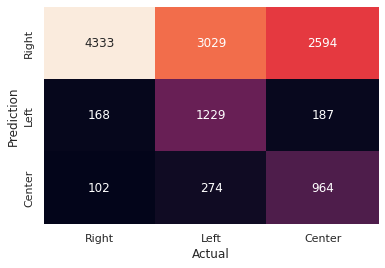

In [ ]:
# balanced data with Oversampling
poly_svm_CV_over = svm.SVC(C=1, kernel='poly')
# training
poly_svm_CV_over.fit(X_train_SMOTE, Y_train_SMOTE["bias_text"])
Y_pred_poly_svm_CV_over = poly_svm_CV_over.predict(count_test)
# accuracy
score_poly_svm_CV_over = metrics.accuracy_score(Y_test_df["bias_text"], Y_pred_poly_svm_CV_over)
print(score_poly_svm_CV_over)

cm_poly_svm_cv_over = metrics.confusion_matrix(Y_test_ser, Y_pred_poly_svm_CV_over, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(cm_poly_svm_cv_over)
# drow heatmap for confusion matrix
sns.heatmap(cm_poly_svm_cv_over.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

imbalanced data, count vector, rbf

0.7481366459627329
[[3784  562  257]
 [ 923 3282  327]
 [ 634  541 2570]]


Text(30.5, 0.5, 'Prediction')

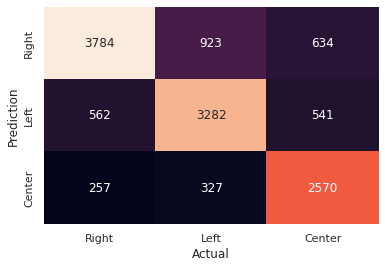

In [ ]:
# imbalanced model
rbf_svm_CV = svm.SVC(C=1, kernel='rbf')
# training
rbf_svm_CV.fit(count_train, Y_train_ser)
Y_pred_rbf_svm_CV = rbf_svm_CV.predict(count_test)
# accuracy
score_rbf_svm_CV = metrics.accuracy_score(Y_test_ser, Y_pred_rbf_svm_CV)
print(score_rbf_svm_CV)

cm_rbf_svm_cv = metrics.confusion_matrix(Y_test_ser, Y_pred_rbf_svm_CV, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(cm_rbf_svm_cv)
# drow heatmap for confusion matrix
sns.heatmap(cm_rbf_svm_cv.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

balanced data with undersampling, count vector, rbf 56min

0.7443322981366459
[[3639  599  365]
 [ 857 3211  464]
 [ 517  491 2737]]


Text(30.5, 0.5, 'Prediction')

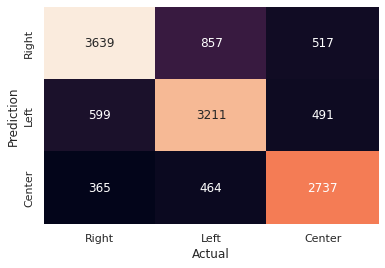

In [ ]:
# balanced data with undersampling
rbf_svm_CV_under = svm.SVC(C=1, kernel='rbf')
# training
rbf_svm_CV_under.fit(count_train_under, Y_train_under["bias_text"])
Y_pred_rbf_svm_CV_under = rbf_svm_CV_under.predict(count_test_under)
# accuracy
score_rbf_svm_CV_under = metrics.accuracy_score(Y_test_df["bias_text"], Y_pred_rbf_svm_CV_under)
print(score_rbf_svm_CV_under)

cm_rbf_svm_cv_under = metrics.confusion_matrix(Y_test_ser, Y_pred_rbf_svm_CV_under, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(cm_rbf_svm_cv_under)
# drow heatmap for confusion matrix
sns.heatmap(cm_rbf_svm_cv_under.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

balanced data with oversampling, count vector, rbf took 2hours 20mins

0.7458850931677019
[[3540  594  469]
 [ 689 3320  523]
 [ 455  543 2747]]


Text(30.5, 0.5, 'Prediction')

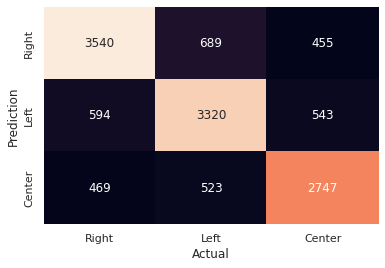

In [ ]:
# balanced data with Oversampling
rbf_svm_CV_over = svm.SVC(C=1, kernel='rbf')
# training
rbf_svm_CV_over.fit(X_train_SMOTE, Y_train_SMOTE["bias_text"])
Y_pred_rbf_svm_CV_over = rbf_svm_CV_over.predict(count_test)
# accuracy
score_rbf_svm_CV_over = metrics.accuracy_score(Y_test_df["bias_text"], Y_pred_rbf_svm_CV_over)
print(score_rbf_svm_CV_over)

cm_rbf_svm_cv_over = metrics.confusion_matrix(Y_test_ser, Y_pred_rbf_svm_CV_over, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(cm_rbf_svm_cv_over)
# drow heatmap for confusion matrix
sns.heatmap(cm_rbf_svm_cv_over.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

imbalanced data, count vector, sigmoid took 1hours 10mins

0.507919254658385
[[2808 1447  348]
 [1679 2505  348]
 [1032 1484 1229]]


Text(30.5, 0.5, 'Prediction')

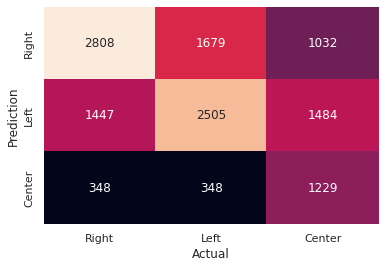

In [ ]:
# imbalanced model
sig_svm_CV = svm.SVC(C=1, kernel='sigmoid')
# training
sig_svm_CV.fit(count_train, Y_train_ser)
Y_pred_sig_svm_CV = sig_svm_CV.predict(count_test)
# accuracy
score_sig_svm_CV = metrics.accuracy_score(Y_test_ser, Y_pred_sig_svm_CV)
print(score_sig_svm_CV)

cm_sig_svm_cv = metrics.confusion_matrix(Y_test_ser, Y_pred_sig_svm_CV, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(cm_sig_svm_cv)
# drow heatmap for confusion matrix
sns.heatmap(cm_sig_svm_cv.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

balanced data with undersampling, count vector, sigmoid took 42mins

0.5329192546583851
[[2308 1465  830]
 [ 834 2468 1230]
 [ 315 1342 2088]]


Text(30.5, 0.5, 'Prediction')

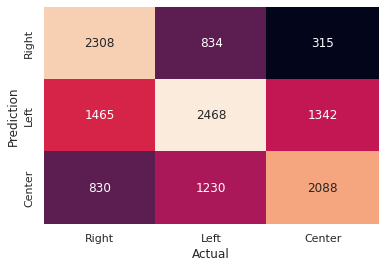

In [ ]:
# balanced data with undersampling
sig_svm_CV_under = svm.SVC(C=1, kernel='sigmoid')
# training
sig_svm_CV_under.fit(count_train_under, Y_train_under["bias_text"])
Y_pred_sig_svm_CV_under = sig_svm_CV_under.predict(count_test_under)
# accuracy
score_sig_svm_CV_under = metrics.accuracy_score(Y_test_df["bias_text"], Y_pred_sig_svm_CV_under)
print(score_sig_svm_CV_under)

cm_sig_svm_cv_under = metrics.confusion_matrix(Y_test_ser, Y_pred_sig_svm_CV_under, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(cm_sig_svm_cv_under)
# drow heatmap for confusion matrix
sns.heatmap(cm_sig_svm_cv_under.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')

balanced data with oversampling, count vector, sigmoid took 2hours 47mins

0.49759316770186335
[[2482 1570  551]
 [1467 2553  512]
 [ 835 1536 1374]]


Text(30.5, 0.5, 'Prediction')

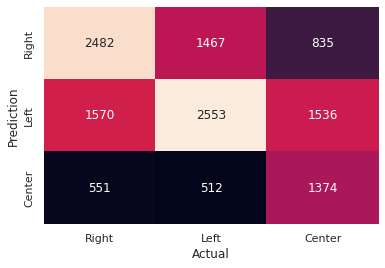

In [ ]:
# balanced data with Oversampling
sig_svm_CV_over = svm.SVC(C=1, kernel='sigmoid')
# training
sig_svm_CV_over.fit(X_train_SMOTE, Y_train_SMOTE["bias_text"])
Y_pred_sig_svm_CV_over = sig_svm_CV_over.predict(count_test)
# accuracy
score_sig_svm_CV_over = metrics.accuracy_score(Y_test_df["bias_text"], Y_pred_sig_svm_CV_over)
print(score_sig_svm_CV_over)

cm_sig_svm_cv_over = metrics.confusion_matrix(Y_test_ser, Y_pred_sig_svm_CV_over, labels=nbdf_filterd_labels)# gotta drop mixed and not rated
print(cm_sig_svm_cv_over)
# drow heatmap for confusion matrix
sns.heatmap(cm_sig_svm_cv_over.T, square=False, annot=True, fmt='d', cbar=False, xticklabels=nbdf_filterd_labels, yticklabels=nbdf_filterd_labels)
plt.xlabel('Actual')
plt.ylabel('Prediction')